In [1]:
## call the main routines
using NBInclude
@nbinclude("core_fun.ipynb");

We fix the parameters for the case of Quebec in an object of type Country. The calibrated values for $\alpha$, $m$ and $q$ (and $\lambda$) are obtained latter on.

In [2]:
lambda_function(q) = 1/quadgk(x-> UIpolicy_quebec(x) * q * exp(-q*x), 0, Inf)[1] 

quebec = let 
    
    reform = 1
    A = 30.  *12 
    Amin = 25. *12
    Amax = 40. *12
    
    r = 0.0048 # 5 % annual interest rate, time unit = month
    c0 = 1. # scale parameter of the cost function, normalized to 1

    ### to be updated after the calibration
    alpha, m, q = 0.5,  0.15,   0.05
    lambdamin = lambda_function(q)
    lambdamax = lambda_function(q)  
    
    uinit = [0.32,0.] ## start with 68% employment rate, 32% without UI
    
    wbar = 1
    b0max = 507 * 12/13924 # 507 and 13924 (average earnings) in 1989 (current dollars), from LM2008
    b0min = 185 * 12/13924 # 185 from LM2008
    bUI = 0.6 ## from Canadian statistics
    
    Country(reform,A,Amin,Amax,r,c0,alpha,q,m,lambdamin,lambdamax,uinit,bUI,b0max,b0min,wbar)
end
;

# 1) Find $\alpha$, $m$ and $q$
We take as moments the employment rates from age 27 to 32.

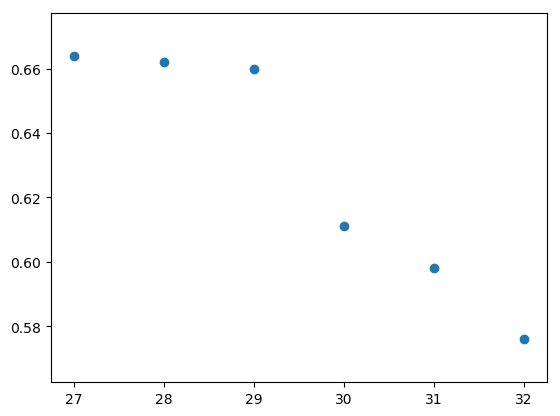

In [3]:
function moments_quebec(unemp, simu::Simu,C::Country)
    Y27 = quadgk(x->1-sum(unemp(x)[:]) ,27*12,27*12+12)[1]/12
    Y28 = quadgk(x->1-sum(unemp(x)[:]) ,28*12,28*12+12)[1]/12
    Y29 = quadgk(x->1-sum(unemp(x)[:]) ,29*12,29*12+12)[1]/12
    Y30 = quadgk(x->1-sum(unemp(x)[:]) ,30*12,30*12+12)[1]/12
    Y31 = quadgk(x->1-sum(unemp(x)[:]) ,31*12,31*12+12)[1]/12
    Y32 = quadgk(x->1-sum(unemp(x)[:]) ,32*12,32*12+12)[1]/12
    return( [Y27, Y28, Y29, Y30, Y31, Y32])
end

moments_target = let
    mom0 = 0.19
    Y27,Y28, Y29, Y30, Y31, Y32 = 0.664, 0.662, 0.660, 0.611, 0.598, 0.576
    scatter(27:32,[Y27,Y28, Y29, Y30, Y31, Y32])
    [Y27, Y28, Y29, Y30, Y31, Y32]
end

function distance(m1,m2)
    out = 0
    for i in 1:length(m1)
        out += (m1[i] - m2[i]) ^2
    end
    return(out)
end
;

We calibrate our model to determine the values of $\alpha$, $m$ and $q$ (and $\lambda$).

In [4]:
## generate a Country object with new values for alpha, m, q and lambda
function update_Country(alpha,m,q,C::Country)
    Country(C.reform,C.A,C.Amin,C.Amax,C.r,C.c0,
        alpha, q, m,lambda_function(q),lambda_function(q),
        C.uinit,C.bUI,C.b0max,C.b0min,C.wbar)
end

## compute the objective to minimise
function objective_qb(alpha,m,q,C::Country)
    newC = update_Country(alpha,m,q,C)
    
    ## simulate
    simu = find_simu(newC,reltol=1e-8)
    unemp = find_unemp(simu, newC, unitSS = false) 
    moments_emp = moments_quebec(unemp,simu,newC)
    
    IJulia.clear_output(true)
    println(alpha," ",m," ",q)
    println(moments_emp)
    
    distance(moments_emp, moments_target) 
end

## distance minimisation with NLopt
@time parmin = let
    opt = Opt(:LN_BOBYQA, 3)
    lower_bounds!(opt, [0.1 , 0., 0.001])
    upper_bounds!(opt, [5. , 1., 0.2])
    #xtol_rel!(opt,1e-12)
    stopval!(opt,1e-15)
    min_objective!(opt, (v,g)-> objective_qb(v[1],v[2],v[3],quebec))
    
    init =  [0.5, 0.2, 0.02  ] 
    
    (minf,minx,ret) = optimize(opt, init) 
    println("Param found with convergence ", ret, ", the value of the objective is ",minf)
    println("alpha, m, q= ", minx[1], " , ",minx[2], "  , ",minx[3])
    minx
end

quebec = update_Country(parmin[1],parmin[2],parmin[3],quebec)

0.5401220613928124 0.1490046419591725 0.0504393217544948
[0.670032, 0.666553, 0.648365, 0.606729, 0.591217, 0.588287]
Param found with convergence ROUNDOFF_LIMITED, the value of the objective is 0.0004077255015970671
alpha, m, q= 0.5401220613928124 , 0.1490046419591725  , 0.0504393217544948
 45.281109 seconds (114.92 M allocations: 5.403 GiB, 8.34% gc time)


Country(1, 360.0, 300.0, 480.0, 0.0048, 1.0, 0.5401220613928124, 0.0504393217544948, 0.1490046419591725, 0.10984585873493173, 0.10984585873493173, [0.32, 0.0], 0.6, 0.4369434070669348, 0.15943694340706693, 1.0, 0.0006920305326670766, 0.013243070264657764)

# 2) Simulation

In [5]:
simu_qb = find_simu(quebec,reltol=1e-5)
unemp_qb = find_unemp(simu_qb, quebec, unitSS = false) 
println("We print the targetted and simulated moments:")
hcat(moments_target, moments_quebec(unemp_qb,simu_qb,quebec)) * 100

We print the targetted and simulated moments:


6×2 Array{Float64,2}:
 66.4  67.0032
 66.2  66.6553
 66.0  64.8365
 61.1  60.6729
 59.8  59.1217
 57.6  58.8287

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the match surplus when a worker receives UI benefits.
The orange continuous curve represents the match surplus when a worker only receives the social assistance.
The dashed curves are the curves for myopic agents.
-----


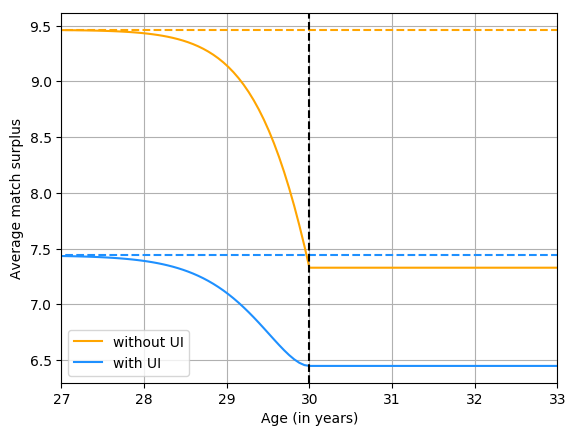

  1.603581 seconds (2.78 M allocations: 142.657 MiB, 4.28% gc time)


In [6]:
@time simuplot_surplus(simu_qb,quebec,xaxis=[27.,33.]*12)

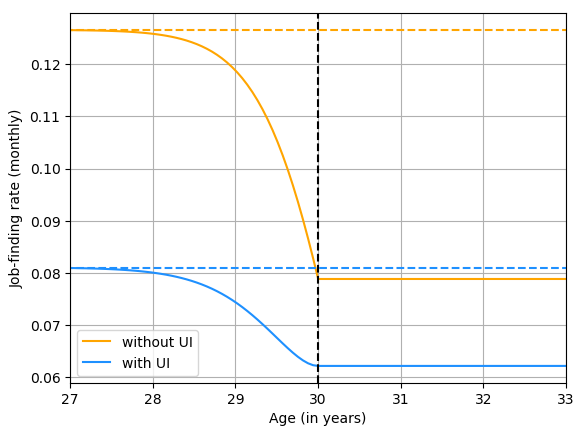

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the job-finding rate when a worker receives UI benefits.
The orange continuous curve represents the job-finding rate when a worker only receives the social assistance.
The dashed curves are the curves for myopic agents.
-----


In [7]:
simuplot_JF(simu_qb,quebec,xaxis=[27.,33.]*12)

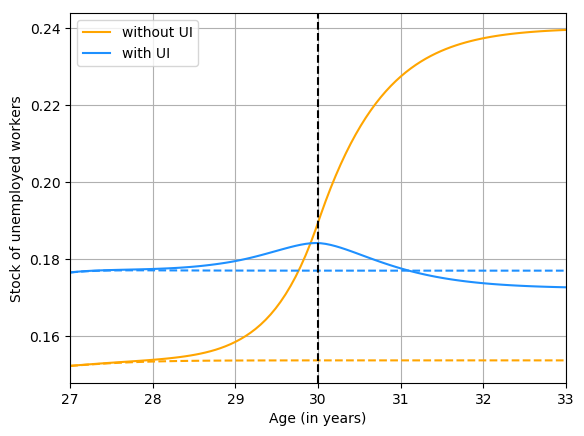

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the unemployement rate with UI benefits.
The orange continuous curve represents the unemployment rate under the social assistance.
The dashed curves give the counterfactual dynamics without a policy change.
-----


In [8]:
unemp_qb_counter0 = find_unemp_counter0(simu_qb, quebec, unitSS = false) 
unemp_qb_counter1 = find_unemp_counter1(simu_qb, quebec, unitSS = false) 
simuplot_unemp(unemp_qb, unemp_qb_counter0, quebec, xaxis =[27,33]*12)

# 3) RDD with simulated model

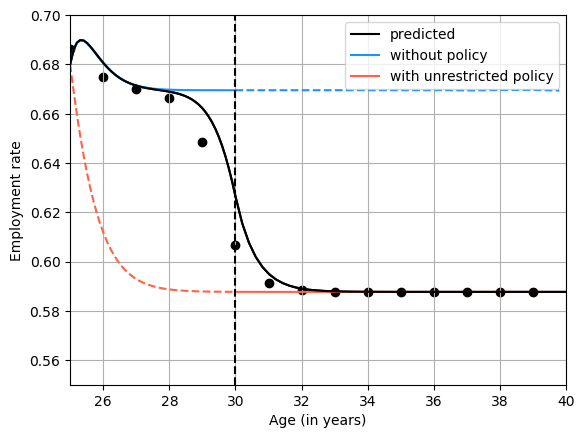

In [9]:
age_grid = 25:39
Y = [quadgk(x->1-sum(unemp_qb(x)[:]) ,m,m+12)[1]/12 for m in 12*age_grid] ## equivalent to ERC in LM2008
simuplot_emp_withpoints(unemp_qb,unemp_qb_counter0, unemp_qb_counter1, age_grid, Y,quebec, yaxis = [0.55,0.7])

We now run the same regressions as in Lemieux and Milligan (2008).

In [10]:
table = zeros(5)

#explaining variables
TREAT = [a>=quebec.A for a in age_grid*12]
consta = ones(size(age_grid))
age1 = collect(age_grid*12)
age2 = age1 .^2
age3 = age1 .^3
age1_spl = (age1 .- quebec.A) .* TREAT 
age2_spl = (age1 .- quebec.A).^2 .* TREAT 

# linear
X = hcat(TREAT, consta, age1)
beta = inv(X' * X) * (X' * Y)
table[1] = beta[1]

# quadratic
X = hcat(TREAT, consta, age1, age2)
beta = inv(X' * X) * (X' * Y)
table[2] = beta[1]

# cubic
X = hcat(TREAT, consta, age1, age2, age3)
beta = inv(X' * X) * (X' * Y)
table[3] = beta[1]

# linear spline
X = hcat(TREAT, consta, age1, age1_spl )
beta = inv(X' * X) * (X' * Y)
table[4] = beta[1]

# quadratic spline
X = hcat(TREAT, consta, age1, age2, age1_spl, age2_spl)
beta = inv(X' * X) * (X' * Y)
table[5] = beta[1]
    
table

5-element Array{Float64,1}:
 -0.06431008502041635
 -0.04656130755776644
 -0.04708082874481079
 -0.04848911118645649
 -0.0369082719233802 

In [11]:
## simulated effect of the policy
emp_after = 1-sum(unemp_qb_counter1(quebec.A)[:])
emp_before = 1-sum(unemp_qb_counter0(quebec.A)[:])
println("The simulated model gives a LATE at ")
emp_after-emp_before

The simulated model gives a LATE at 


-0.08181855598958054